## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (and make it a script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells` as often as needed.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Simple Data Analysis and Linear and MLP Regression Modelling

## The `housing` problem

We want to predict median house values in suburbs of Boston.

Accesible en https://archive.ics.uci.edu/ml/datasets/Housing

### Attribute Information:

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per \$10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in \$1000's

**Lately it has been pointed out that this dataset may present ethical and methodological problems with respect the `B` variable.**  
See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html for more info.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import time
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

## Data Loading

The dataset is preloaded in the sciki-learn library.

In [4]:
boston = load_boston()

df_housing = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df_housing['MEDV'] = boston['target']

vars_housing   = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', \
                  'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
target_housing = ['MEDV']

print ("nFilas: %d\tnColumnas: %d\n" % (df_housing.shape[0], df_housing.shape[1]) )
print ("Columnas:\t", np.array(df_housing.columns))

nFilas: 506	nColumnas: 14

Columnas:	 ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'MEDV']


In [5]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms

### Descriptive analysis

In [6]:
df_housing.describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.61,8.60,0.01,0.08,0.26,3.68,88.98
ZN,506.0,11.36,23.32,0.00,0.00,0.00,12.50,100.00
INDUS,506.0,11.14,6.86,0.46,5.19,9.69,18.10,27.74
CHAS,506.0,0.07,0.25,0.00,0.00,0.00,0.00,1.00
NOX,506.0,0.55,0.12,0.38,0.45,0.54,0.62,0.87
RM,506.0,6.28,0.70,3.56,5.89,6.21,6.62,8.78
AGE,506.0,68.57,28.15,2.90,45.02,77.50,94.07,100.00
DIS,506.0,3.80,2.11,1.13,2.10,3.21,5.19,12.13
RAD,506.0,9.55,8.71,1.00,4.00,5.00,24.00,24.00
TAX,506.0,408.24,168.54,187.00,279.00,330.00,666.00,711.00


THere are no  missing values and value ranges appear to be reasonable.

## Boxplots, histograms and scatterplots

### Boxplots

We normalize the data so that all boxplots are in a similar scale.

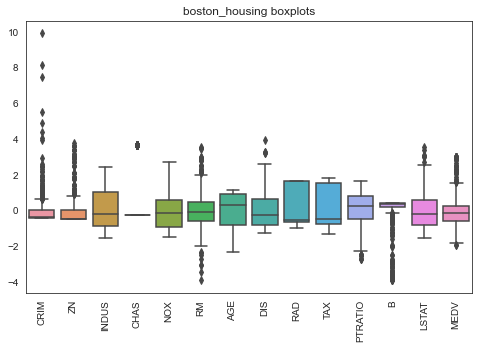

In [7]:
#normalizamos para tener rangos uniformes en histogramas
df_housing_normalizado = (df_housing - df_housing.mean()) / df_housing.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
#bxplot = sns.boxplot(data=df_housing)
boxplot = sns.boxplot(data=df_housing_normalizado)
plt.title("boston_housing boxplots")
plt.xticks(rotation=90)
plt.show()

### Histograms and scatterplots

Histograms and scatter plots against the target of first 7 fatures.

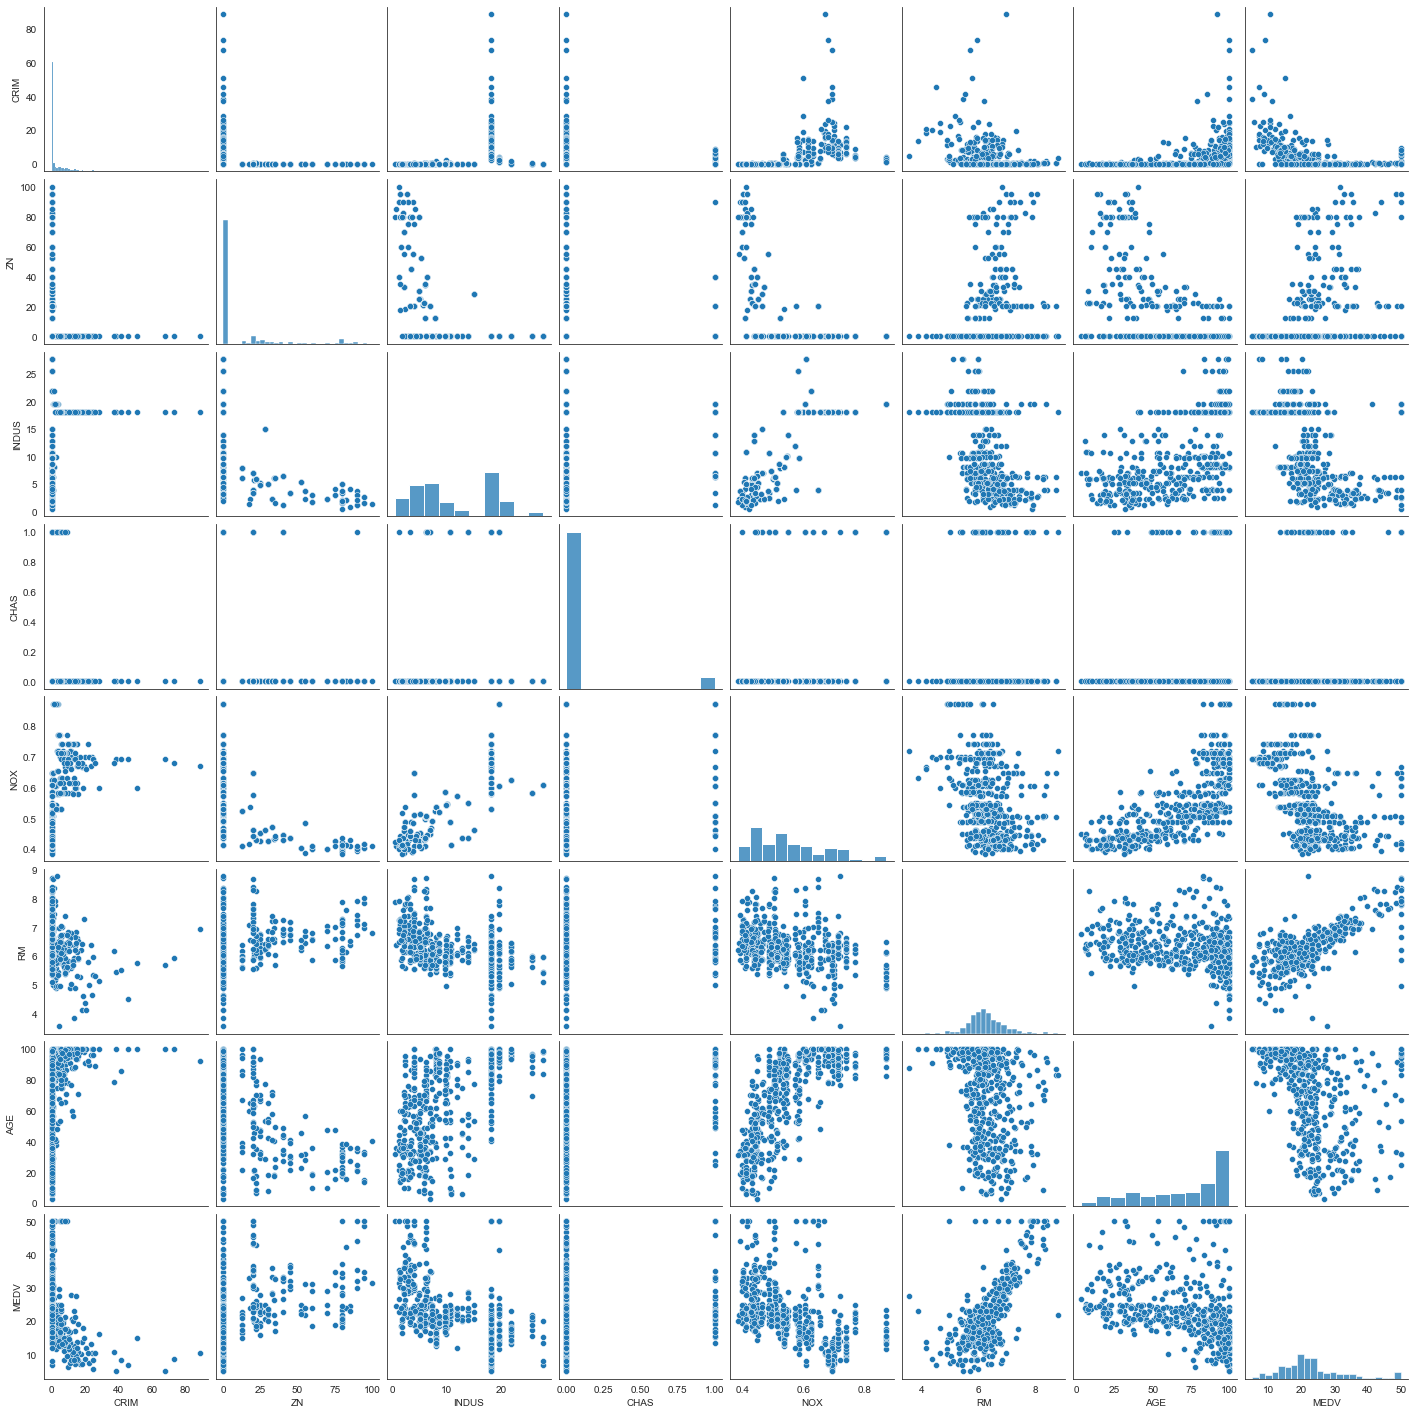

In [8]:
num_vars_to_show = 7 
pair_plot = sns.pairplot( df_housing[ vars_housing[ : num_vars_to_show] + target_housing] )
plt.show()

Histograms and scatter plots against the target of remaining features.

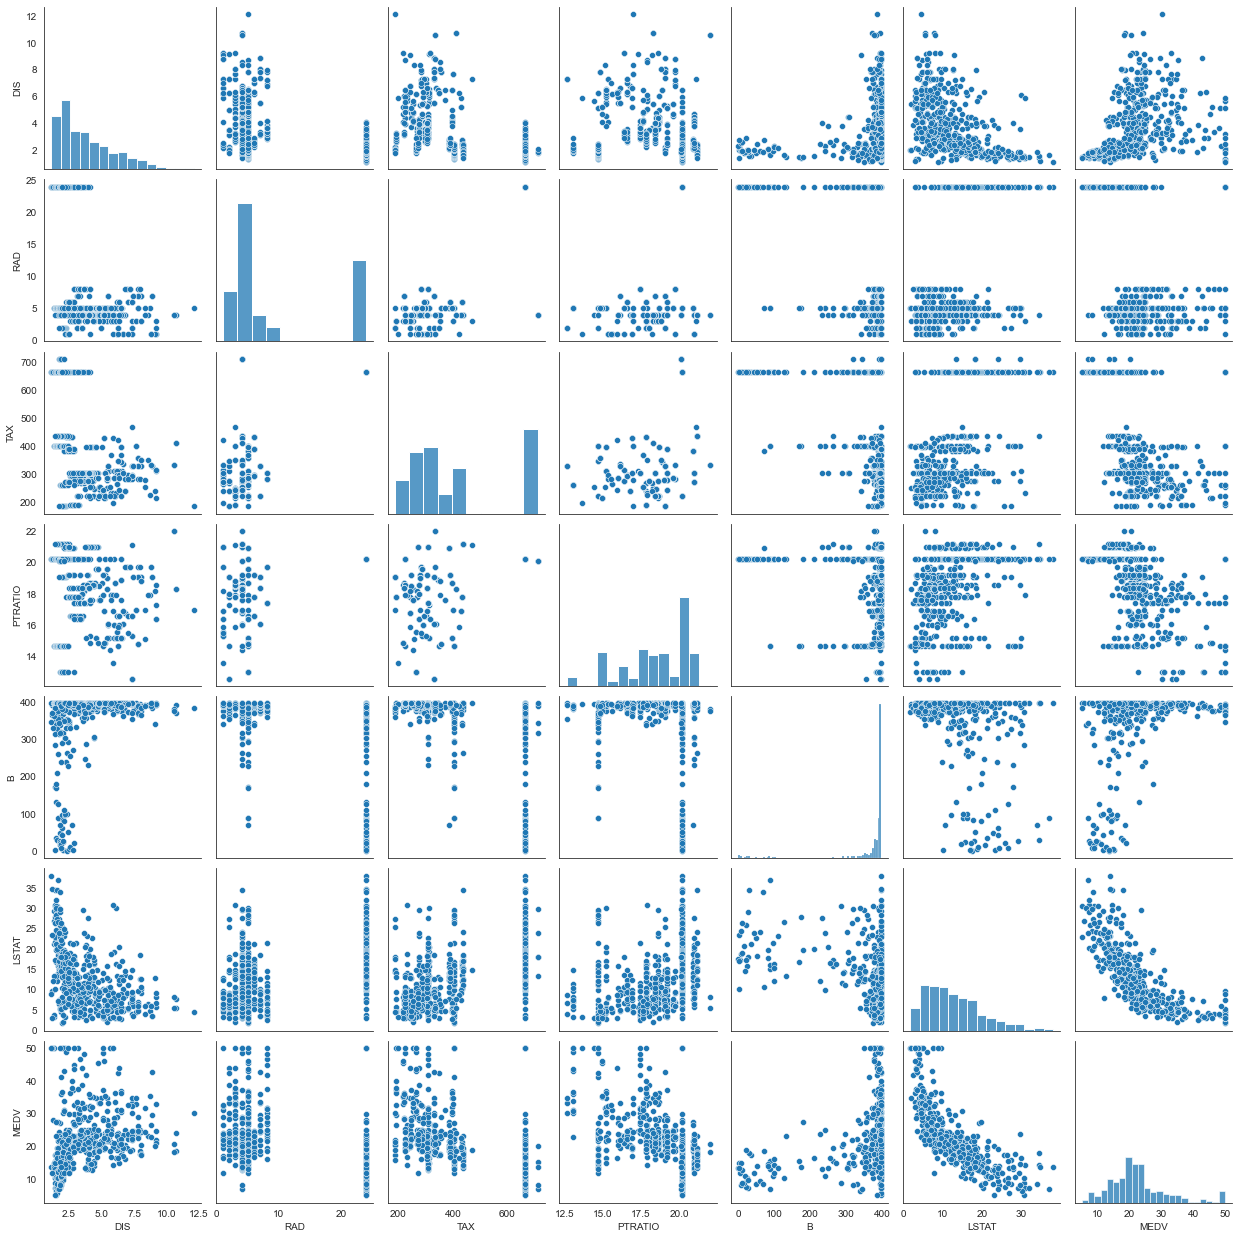

In [9]:
pair_plot = sns.pairplot( df_housing[ vars_housing[ 7: ] + target_housing] )
plt.show()

A few variables seem to have a linear relationship with the target.

### Correlations

In [10]:
df_housing.corr().round(decimals=3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,-0.385,0.456,-0.388
ZN,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,0.176,-0.413,0.360
INDUS,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,-0.357,0.604,-0.484
CHAS,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,0.049,-0.054,0.175
NOX,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,-0.380,0.591,-0.427
RM,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,0.128,-0.614,0.695
AGE,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,-0.274,0.602,-0.377
DIS,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,0.292,-0.497,0.250
RAD,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,-0.444,0.489,-0.382
TAX,0.583,-0.315,0.721,-0.036,0.668,-0.292,0.506,-0.534,0.910,1.000,0.461,-0.442,0.544,-0.469


Una imagen (o un heatmap) vale más que mil palabras

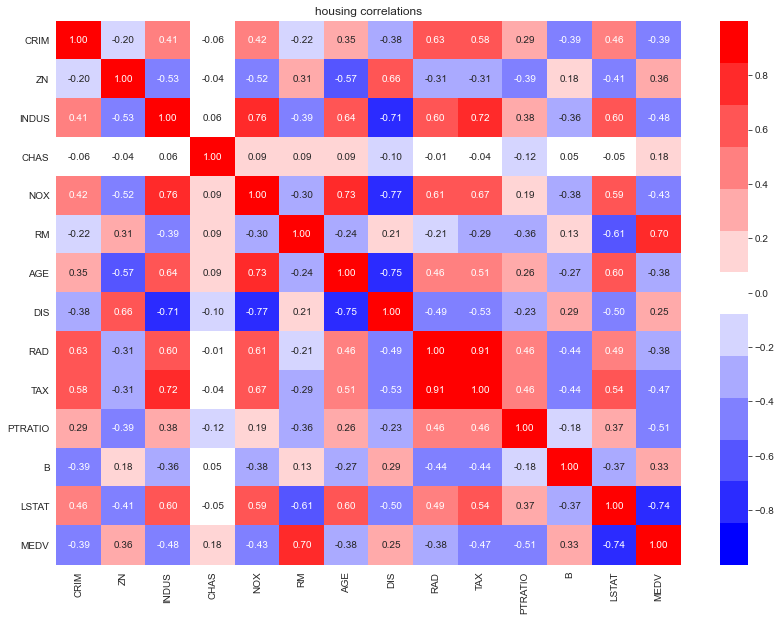

In [11]:
# definir el color map
n_colors = 13
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

# definir el heatmap
fig = plt.figure( figsize=(14, 10))
plt.title('housing correlations')
#plt.colorbar(cMap, ticks=[-1, 0, 1])
h_map = sns.heatmap(df_housing.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    fmt='.2f',
                    xticklabels=list(df_housing.columns),
                    yticklabels=list(df_housing.columns))
plt.xticks(rotation=90) 

# poner ticks en la barra de color
cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

# generar el dibujo
plt.show()

In [12]:
print( ( df_housing.corr()['MEDV'].round(3).sort_values(ascending=False).T) )

MEDV       1.000
RM         0.695
ZN         0.360
B          0.333
DIS        0.250
CHAS       0.175
AGE       -0.377
RAD       -0.382
CRIM      -0.388
NOX       -0.427
TAX       -0.469
INDUS     -0.484
PTRATIO   -0.508
LSTAT     -0.738
Name: MEDV, dtype: float64


# Ridge Regression

To get started, we define and fit a first model, plot its coefficients and measure errors (though not in a correct way).

model intercept: 22.533


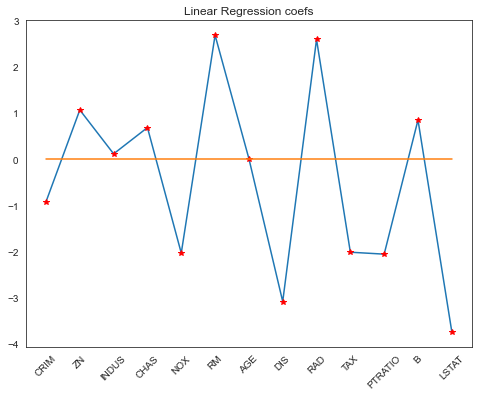

In [13]:
std_sc = StandardScaler()
x = std_sc.fit_transform(boston['data'])
y = boston['target']

lr_m =  Ridge()
#ajuste sobre la muestra completa, sin split train-test
lr_m.fit(x, y)

#print("model intercept: %.3f}" % lr_m.intercept_)
print("model intercept: {0:.3f}".format(lr_m.intercept_))

plt.figure(figsize=(8, 6))
plt.xticks(range(len(vars_housing)), vars_housing, rotation=45)
plt.title('Linear Regression coefs')
_ = plt.plot(lr_m.coef_.T, '-', lr_m.coef_.T, 'r*', 0. * lr_m.coef_.T, '-')

MAE: 3.226	R^2: 0.741


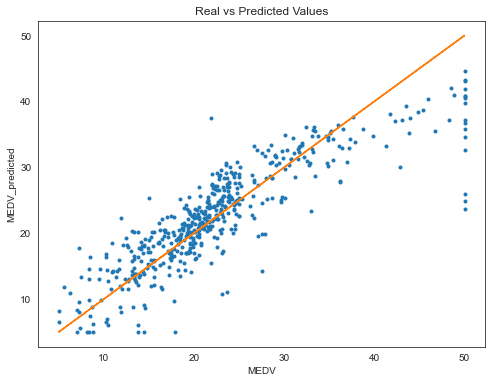

In [14]:
y_pred = np.clip(lr_m.predict(x), 5.,  50.)
#y_pred = lr_m.predict(x)

print("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error(y, y_pred), lr_m.score(x, y)))

plt.figure(figsize=(8, 6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

### Estimating model performance

We get a more realistic evaluation through Cross Validation over 10 random folds.

In [15]:
n_folds = 10
kf = KFold(n_folds, shuffle=True)

scores = cross_val_score(lr_m, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))
print("scores:\n", -np.round(scores, 3))

mae_mean: 3.398		mae_std: 0.505
scores:
 [2.796 3.955 3.457 3.489 2.981 2.85  3.375 3.338 4.556 3.183]


### Finding the optimal `alpha` by Grid Search CV

 We select the ridge parameter `alpha` by CV.

In [16]:
# First iteration to find alpha

# define pipelined ridge model
rr = Ridge()
rr_pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                          ('rr', rr)])
    
# define folds
n_folds = 10
kf = KFold(n_folds, shuffle=True)

# define param_grid
l_alpha = [10.**k for k in range(-6, 5)]
param_grid = {'rr__alpha': l_alpha}

#y_transformer = StandardScaler()
#inner_rr = TransformedTargetRegressor(regressor=rr_pipe,
#                                      transformer=y_transformer)

cv_estimator= GridSearchCV(rr_pipe, 
                           param_grid=param_grid, 
                           cv=kf, 
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1, 
                           verbose=1)

_ = cv_estimator.fit(x, y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


### Analyzing GridSearchCV results

We check the adequacy of the best hyperparameter and plot the CV errors with respect to `alpha`.

In [17]:
df_cv_estimator = pd.DataFrame.from_dict(cv_estimator.cv_results_)

display(df_cv_estimator[["param_rr__alpha", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_rr__alpha,mean_test_score
7,10.0,-3.368137
8,100.0,-3.385859
6,1.0,-3.396077
5,0.1,-3.400152
4,0.01,-3.400580


alpha_range: 0 - 10000
alpha = 10
best_cv_mae = 3.368


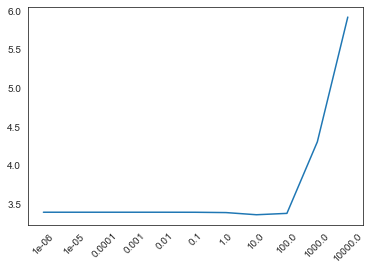

In [18]:
print("alpha_range: %.f - %.f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('alpha = %.f' % (cv_estimator.best_params_['rr__alpha']))
print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -df_cv_estimator['mean_test_score'])

### Repeat if needed

We perform a second grid search on a narrower region around the optimum `alpha` just found.

In [19]:
#Segunda iteración: recentramos alpha y refinamos la búsqueda
kf = KFold(n_folds, shuffle=True)

l_alpha = [cv_estimator.best_params_['rr__alpha'] + k for k in range(-10, 100, 10)]
param_grid = {'rr__alpha': l_alpha}

cv_estimator_2= GridSearchCV(rr_pipe, 
                             param_grid=param_grid, 
                             cv=kf, 
                             scoring='neg_mean_absolute_error',
                             n_jobs=-1, 
                             verbose=1)

_ = cv_estimator_2.fit(x, y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


,param_rr__alpha,mean_test_score
4,40.0,-3.331047
3,30.0,-3.333238
5,50.0,-3.334355
2,20.0,-3.339653
6,60.0,-3.341080


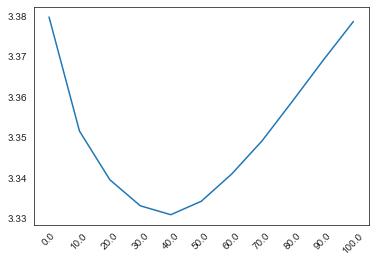

In [20]:
df_cv_estimator_2 = pd.DataFrame.from_dict(cv_estimator_2.cv_results_)

display(df_cv_estimator_2[["param_rr__alpha", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -df_cv_estimator_2['mean_test_score'])

## Testing the final model

We do it first by CV scores.

In [21]:
best_rr = cv_estimator_2.best_estimator_

rr_scores = cross_val_score(best_rr, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)
print("ridge mae_mean: %.3f\t\tmae_std: %.3f" % (-rr_scores.mean(), rr_scores.std()))

ridge mae_mean: 3.310		mae_std: 0.413


We can get CV fold predictions by pattern with `cross_val_predict`.

ridge mae: 3.302


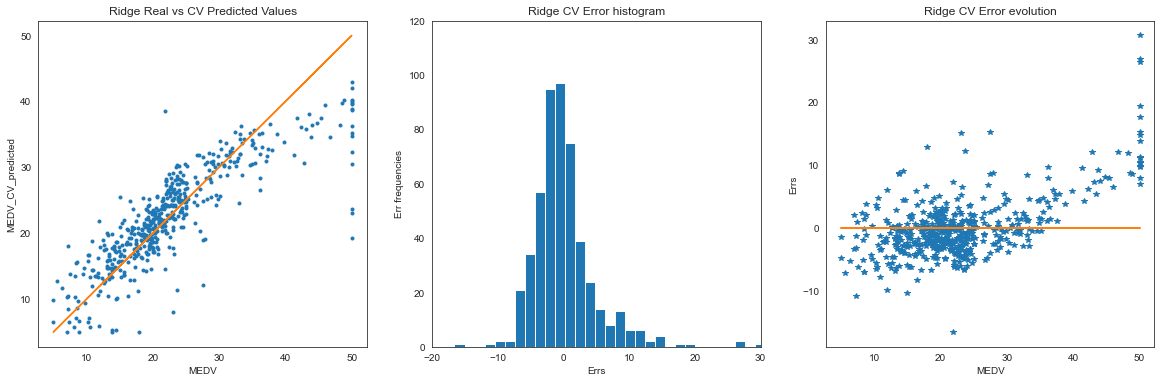

In [22]:
y_pred_rr = np.clip( cross_val_predict(best_rr, x, y, cv=kf, n_jobs=-1), 5., 50.)
err_rr = y - y_pred_rr

print("ridge mae: %.3f" % (abs(err_rr).mean()) )

plt.figure( figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title('Ridge Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred_rr, '.', y, y, '-')

plt.subplot(1, 3, 2)
plt.title("Ridge CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-20, 30)
plt.ylim(0, 120)
_ = plt.hist(err_rr, bins=31)

plt.subplot(1, 3, 3)
plt.title("Ridge CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err_rr, '*', y, 0.*y, '-')

## Huber Regression

### Finding the optimal `alpha` by Grid Search CV

 We select the ridge parameter `alpha` by CV.

In [23]:
# First iteration to find alpha

# define folds
n_folds = 10
kf = KFold(n_folds, shuffle=True)

# define param_grid
l_alpha = [10.**k for k in range(-6, 3)]
param_grid = {'alpha': l_alpha}

# define grid search
hr_m = HuberRegressor()
huber_cv_estimator = GridSearchCV(hr_m, 
                                  param_grid=param_grid, 
                                  cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=-1, 
                                  verbose=1)

_ = huber_cv_estimator.fit(x, y)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [24]:
df_huber_cv = pd.DataFrame.from_dict(huber_cv_estimator.cv_results_)

display(df_huber_cv[["param_alpha", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_alpha,mean_test_score
6,1.0,-3.206515
5,0.1,-3.210936
4,0.01,-3.211528
3,0.001,-3.211586
2,0.0001,-3.211592


### Analyzing GridSearchCV results

We check the adequacy of the best hyperparameter and plot the CV errors with respect to `alpha`.

alpha_range: 0.00 - 100.00
alpha = 1.00
best_cv_mae = 3.207


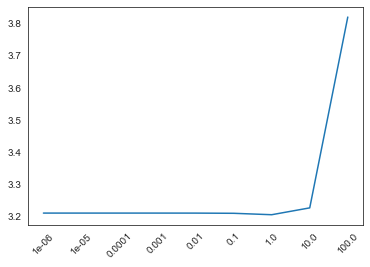

In [25]:
print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('alpha = %.2f' % (huber_cv_estimator.best_params_['alpha']))

print('best_cv_mae = %.3f' % (-huber_cv_estimator.best_score_))

plt.xticks(list(range(len(l_alpha))), l_alpha, rotation=45)
_ = plt.plot( -df_huber_cv['mean_test_score'])

## Testing the final model

We do it first by CV.

In [26]:
ridge_scores = cross_val_score(cv_estimator_2.best_estimator_, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)
print("ridge mae_mean: %.3f\t\tmae_std: %.3f" % (-ridge_scores.mean(), ridge_scores.std()))

huber_scores = cross_val_score(huber_cv_estimator.best_estimator_, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)
print("huber mae_mean: %.3f\t\tmae_std: %.3f" % (-huber_scores.mean(), huber_scores.std()))

ridge mae_mean: 3.390		mae_std: 0.667
huber mae_mean: 3.208		mae_std: 0.398


We can get CV fold predictions with `cross_val_predict`.

In [27]:
y_pred_ridge = np.clip( cross_val_predict(cv_estimator_2.best_estimator_, x, y, cv=kf), 5., 50.)

y_pred_huber = np.clip( cross_val_predict(huber_cv_estimator.best_estimator_, x, y, cv=kf), 5., 50.)

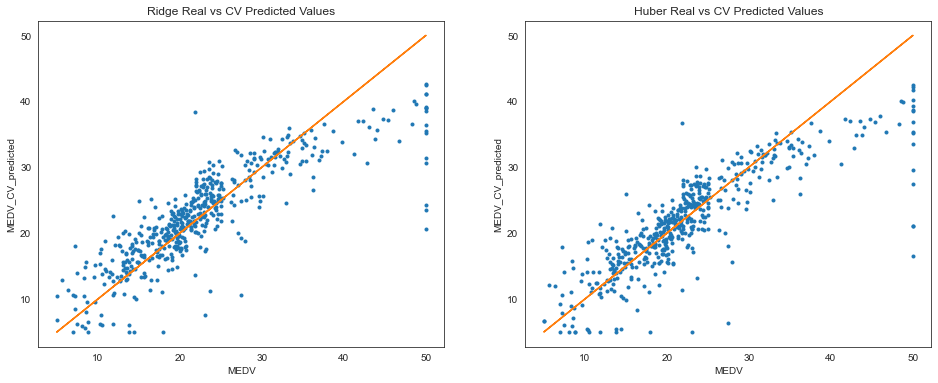

In [28]:
plt.figure( figsize=(16,6))

plt.subplot(1, 2, 1)
plt.title('Ridge Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred_ridge, '.', y, y, '-')

plt.subplot(1, 2, 2)
plt.title('Huber Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y, y_pred_huber, '.', y, y, '-')

### Residual histograms and relationship with targets

ridge mae: 3.314
huber mae: 3.164


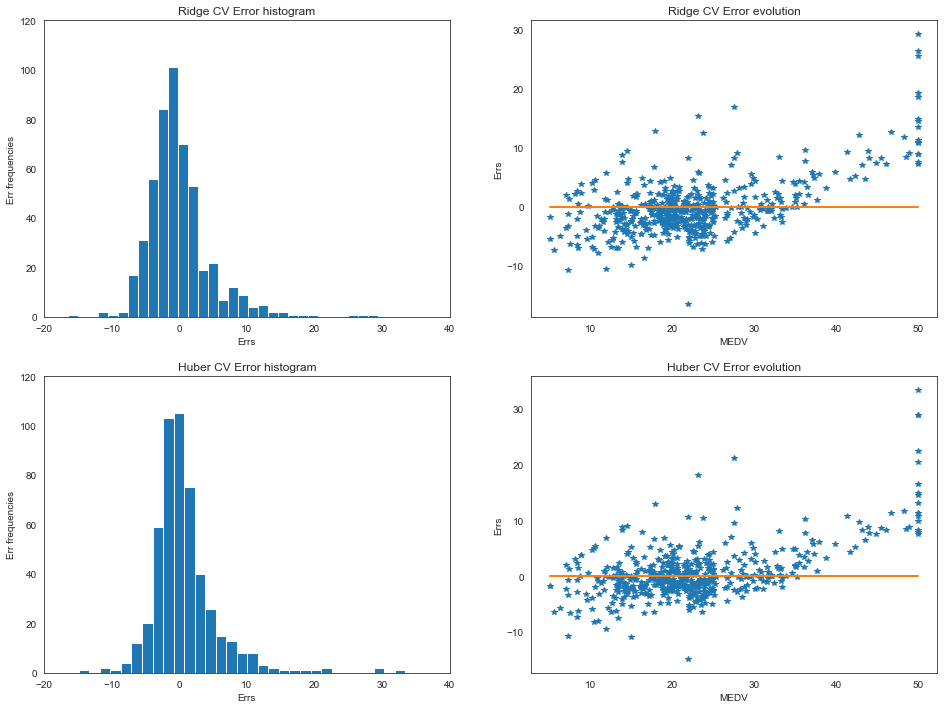

In [29]:
err_ridge = y - y_pred_ridge
print("ridge mae: %.3f" % (abs(err_ridge).mean()) )

err_huber = y - y_pred_huber
print("huber mae: %.3f" % (abs(err_huber).mean()) )

plt.figure( figsize=(16,12))

plt.subplot(2,2,1)
plt.title("Ridge CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-20, 40)
plt.ylim(0, 120)
_ = plt.hist(err_ridge, bins=31)

plt.subplot(2,2,2)
plt.title("Ridge CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err_ridge, '*', y, 0.*y, '-')

plt.subplot(2,2,3)
plt.title("Huber CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-20, 40)
plt.ylim(0, 120)
_ = plt.hist(err_huber, bins=31)

plt.subplot(2,2,4)
plt.title("Huber CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err_huber, '*', y, 0.*y, '-')

plt.show()

## Tweaking the data set?

Just drop the 50 targets.

Perhaps this makes models easier to train?

In [30]:
idx_50 = (y == 50.)

x_cl = x[~idx_50]
y_cl = y[~idx_50]

print(x_cl.shape)

(490, 13)


### Finding the optimal Ridge `alpha` by Grid Search CV

In [31]:
# First iteration to find alpha

# define pipelined ridge model
rr = Ridge()
rr_pipe = Pipeline(steps=[('std_sc', StandardScaler()),
                          ('rr', rr)])
    
# define folds
n_folds = 10
kf = KFold(n_folds, shuffle=True)

# define param_grid
l_alpha = [10.**k for k in range(-6, 5)]
param_grid = {'rr__alpha': l_alpha}

#y_transformer = StandardScaler()
#inner_rr = TransformedTargetRegressor(regressor=rr_pipe,
#                                      transformer=y_transformer)

ridge_cv_estimator= GridSearchCV(rr_pipe, 
                           param_grid=param_grid, 
                           cv=kf, 
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1, 
                           verbose=1)

_ = ridge_cv_estimator.fit(x_cl, y_cl)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


### Finding the optimal Huber `alpha` by Grid Search CV

In [32]:
# First iteration to find alpha

# define folds
n_folds = 10
kf = KFold(n_folds, shuffle=True)

# define param_grid
l_alpha = [10.**k for k in range(-6, 3)]
param_grid = {'alpha': l_alpha}

# define grid search
hr_m = HuberRegressor()
huber_cv_estimator = GridSearchCV(hr_m, 
                                  param_grid=param_grid, 
                                  cv=kf, 
                                  scoring='neg_mean_absolute_error',
                                  n_jobs=-1, 
                                  verbose=1)

_ = huber_cv_estimator.fit(x_cl, y_cl)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


## Testing the final models

We do it first by CV on the clean data.

In [33]:
ridge_scores = cross_val_score(ridge_cv_estimator.best_estimator_, x_cl, y_cl, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)
print("ridge mae_mean: %.3f\t\tmae_std: %.3f" % (-ridge_scores.mean(), ridge_scores.std()))

huber_scores = cross_val_score(huber_cv_estimator.best_estimator_, x_cl, y_cl, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)
print("huber mae_mean: %.3f\t\tmae_std: %.3f" % (-huber_scores.mean(), huber_scores.std()))

ridge mae_mean: 2.847		mae_std: 0.177
huber mae_mean: 2.765		mae_std: 0.366


Then we do it by CV on the full data set.

In [34]:
ridge_scores = cross_val_score(ridge_cv_estimator.best_estimator_, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)
print("ridge mae_mean: %.3f\t\tmae_std: %.3f" % (-ridge_scores.mean(), ridge_scores.std()))

huber_scores = cross_val_score(huber_cv_estimator.best_estimator_, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)
print("huber mae_mean: %.3f\t\tmae_std: %.3f" % (-huber_scores.mean(), huber_scores.std()))

ridge mae_mean: 3.389		mae_std: 0.543
huber mae_mean: 3.208		mae_std: 0.406
